In [89]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import ase.io
from time import time
from copy import deepcopy

from aml_storage import Labels, Block, Descriptor

from utils.librascal import RascalSphericalExpansion
from utils.clebsh_gordan import ClebschGordanReal

from utils.acdc import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This example demonstrates the iterative construction of atom-centered density correlations.
The calculations incorporate ideas from the N-body iterative contraction of equivariants [paper](https://doi.org/10.1063/5.0021116) and the optimal radial basis [paper](https://doi.org/10.1063/5.0057229).

# Covariance-optimal basis

We start by computing the spherical expansion representation for a set of methane structures. 

In [155]:
rascal_hypers = {
    "interaction_cutoff": 3.5,
    "cutoff_smooth_width": 0.5,
    "max_radial": 3,
    "max_angular": 2,
    "gaussian_sigma_type": "Constant",
    "compute_gradients":  True,
}

nmax, lmax = rascal_hypers["max_radial"], rascal_hypers["max_angular"]
calculator = RascalSphericalExpansion(rascal_hypers)

In [156]:
frames = ase.io.read("./data/random-methane-10k.extxyz", "::100")
for f in frames:
    f.cell = [100,100,100]
    f.positions += 50

In [157]:
density_expansion = calculator.compute(frames)

/home/michele/lavoro/code/aml-storage-examples/utils/librascal.py:92: UserWarning: numpy/forward gradients are currently broken with librascal,please use rascaline instead
  warnings.warn(


Then, select the C,H block, which is the most significant for this dataset, and project to the optimal covariance basis.

In [158]:
# for each (C,H) block, construct the optimal covariance basis
opt_eve = {}
opt_eva = {}
full_norms = np.zeros(len(frames))
for index, block in density_expansion:
    if index["center_species"] == 6 and index["neighbor_species"] == 1:
        feats = block.values.reshape(-1, len(block.features))
        full_norms += (block.values**2).sum(axis=-1).sum(axis=-1)
        cov = feats.T @ feats / feats.shape[0]
        eva, eve = sp.linalg.eigh(cov)
        eva = eva[::-1]; eve = eve[:,::-1]
        opt_eva[index["spherical_harmonics_l"]] = eva
        opt_eve[index["spherical_harmonics_l"]] = eve

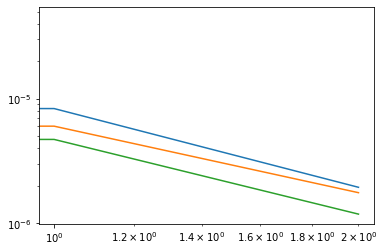

In [159]:
for l in range(lmax+1):
    plt.loglog(opt_eva[l])

Create compressed features, using labels naming consistent with Nigam 2020

In [162]:
sel_thresh = 1.5e-6
blocks = []
for l in range(lmax+1):
    n_selected = len(np.where(opt_eva[l] > sel_thresh)[0])    
    de_block = density_expansion.block(center_species = 6, neighbor_species=1, spherical_harmonics_l = l)
    block = Block(
        values = de_block.values@opt_eve[l][:,:n_selected],
        samples = de_block.samples,
        components = Labels(["m"],np.asarray(range(-l,l+1), dtype=np.int32).reshape(-1,1)),
        features = Labels(["n"], np.asarray([[n] for n in range(n_selected)], dtype=np.int32))
    )
    if rascal_hypers["compute_gradients"]:
        de_grad = de_block.gradient("positions")
        block.add_gradient(
            parameter="positions",
            gradient_samples=de_grad[0],
            gradient=de_grad[1]@opt_eve[l][:,:n_selected],
        )
    blocks.append( block )

In [163]:
acdc_nu1 = Descriptor(sparse = Labels(names=["sigma", "lam", "nu"], 
                                      values=np.asarray([[ 1, l, 1] for l in range(rascal_hypers["max_angular"]+1)], dtype=np.int32)), 
                      blocks = blocks
                     )

In [164]:
# multiplicity of the features, stored as a descriptor array
acdc_full_nu1 = Descriptor(
    sparse = acdc_nu1.sparse,
    blocks = [
        Block(
            values = np.ones(shape=(1,1,len(acdc_nu1.block(s).features))),
            samples = Labels(["dummy"], np.zeros(shape=(1,1), dtype=np.int32)),
            components = Labels(["dummy"], np.zeros(shape=(1,1), dtype=np.int32)),
            features = acdc_nu1.block(s).features
        ) for s in acdc_nu1.sparse
    ]
)

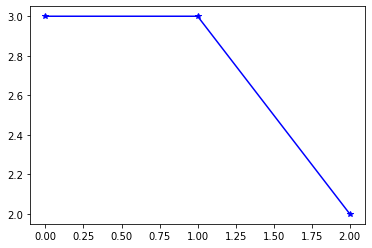

In [165]:
ln_nu1 = np.asarray([[s["lam"], b.values.shape[-1]] for s,b in acdc_nu1 ])
plt.plot(ln_nu1[:,0], ln_nu1[:,1], 'b*-')

# ACDC utilities

In [166]:
cg = ClebschGordanReal(lmax*3)

default (all to all)

In [169]:
%%time
acdc_nu2 = cg_increment(acdc_nu1, acdc_nu1, clebsch_gordan=cg)

CPU times: user 62.8 ms, sys: 0 ns, total: 62.8 ms
Wall time: 62.1 ms


In [170]:
%%time
acdc_nu2_builder = cg_increment_builder(acdc_nu1, acdc_nu1, clebsch_gordan=cg)

CPU times: user 60.1 ms, sys: 0 ns, total: 60.1 ms
Wall time: 59.2 ms


In [171]:
acdc_nu2_builder.sparse

Labels([( 1, 0, 2), ( 1, 1, 2), ( 1, 2, 2), (-1, 1, 2), (-1, 2, 2),
        ( 1, 3, 2), (-1, 3, 2), ( 1, 4, 2)],
       dtype=[('sigma', '<i4'), ('lam', '<i4'), ('nu', '<i4')])

In [172]:
for i in range(len(acdc_nu2.sparse)):
    print(np.linalg.norm(
        acdc_nu2.block(acdc_nu2.sparse[1]).values - acdc_nu2_builder.block(acdc_nu2.sparse[1]).values
    ))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


specifying features

In [173]:
%%time
acdc_nu2 = cg_increment(acdc_nu1, acdc_nu1, acdc_full_nu1, acdc_full_nu1, clebsch_gordan=cg)
acdc_full_nu2 = full_product_indices(acdc_full_nu1, acdc_full_nu1)

CPU times: user 74.2 ms, sys: 0 ns, total: 74.2 ms
Wall time: 73.4 ms


In [174]:
%%time
acdc_nu3 = cg_increment(acdc_nu2, acdc_nu1, acdc_full_nu2, acdc_full_nu1, clebsch_gordan = cg)

CPU times: user 1.02 s, sys: 89 ms, total: 1.11 s
Wall time: 1.11 s


In [175]:
features_norm(acdc_nu3).mean()

9.607837605262184e-12

In [176]:
(norm_full1**3).mean()

9.607837605262195e-12

## analyze jacobian

Requires `compute_gradients=True`

manually densify features

In [177]:
j_nu1 = []
for idx, block in acdc_nu1:
    smp, grad = block.gradient("positions")
    j_nu1.append(grad.reshape((grad.shape[0],-1)))
j_nu1 = np.concatenate(j_nu1, axis=-1).reshape(10,12,-1)    

In [178]:
j_nu2 = []
for idx, block in acdc_nu2:
    smp, grad = block.gradient("positions")
    j_nu2.append(grad.reshape((grad.shape[0],-1)))
j_nu2 = np.concatenate(j_nu2, axis=-1).reshape(10,12,-1)

In [179]:
j_nu3 = []
for idx, block in acdc_nu3:
    smp, grad = block.gradient("positions")
    j_nu3.append(grad.reshape((grad.shape[0],-1)))
j_nu3 = np.concatenate(j_nu3, axis=-1).reshape(10,12,-1)

sv_nu3 = np.asarray([ sp.linalg.svdvals(j_nu3[i])  for i in range(10)])

In [180]:
import scipy as sp

In [181]:
sv_nu1 = np.asarray([ sp.linalg.svdvals(j_nu1[i])  for i in range(10)])
sv_nu2 = np.asarray([ sp.linalg.svdvals(j_nu2[i])  for i in range(10)])

Text(0, 0.5, 'CN ($\\nu=2)$')

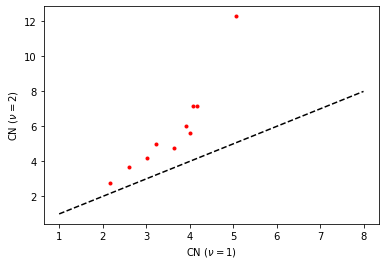

In [182]:
plt.plot(
    sv_nu1[:,0]/sv_nu1[:,-1],
    sv_nu2[:,0]/sv_nu2[:,-1],
    'r.'
)
plt.plot([1,8],[1,8],'k--')
plt.xlabel(r"CN ($\nu=1)$")
plt.ylabel(r"CN ($\nu=2)$")

Text(0, 0.5, 'CN ($\\nu=3)$')

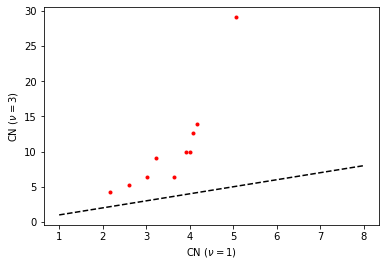

In [183]:
plt.plot(
    sv_nu1[:,0]/sv_nu1[:,-1],
    sv_nu3[:,0]/sv_nu3[:,-1],
    'r.'
)
plt.plot([1,8],[1,8],'k--')
plt.xlabel(r"CN ($\nu=1)$")
plt.ylabel(r"CN ($\nu=3)$")

# Independent feature tracking

This performs the cg iteration while avoiding to compute duplicate / linearly dependent features, and tracks the multiplicity so that no density (correlation) is lost

In [184]:
%%time 
cg = ClebschGordanReal(12)

CPU times: user 8.14 s, sys: 8.48 s, total: 16.6 s
Wall time: 2.67 s


In [62]:
%%time 
cg = ClebschGordanReal(lmax*5)

CPU times: user 1.98 s, sys: 2.22 s, total: 4.2 s
Wall time: 562 ms


In [185]:
norm_full1 = features_norm(acdc_nu1)

In [186]:
acdc_sel_nu2 = canonical_indices(acdc_full_nu1, acdc_full_nu1)

In [187]:
%%time
canonical_acdc_nu2 = cg_increment(acdc_nu1, acdc_nu1, acdc_full_nu1, acdc_full_nu1, clebsch_gordan=cg, M=acdc_sel_nu2)

CPU times: user 68.6 ms, sys: 63 µs, total: 68.7 ms
Wall time: 73.2 ms


In [188]:
acdc_sel_nu3 = canonical_indices(acdc_sel_nu2, acdc_full_nu1)

In [191]:
%%time
canonical_acdc_nu3 = cg_increment_builder(canonical_acdc_nu2, acdc_nu1, acdc_sel_nu2, acdc_full_nu1, clebsch_gordan=cg, 
                                    M=acdc_sel_nu3)

CPU times: user 445 ms, sys: 0 ns, total: 445 ms
Wall time: 444 ms


In [68]:
acdc_sel_nu4 = canonical_indices(acdc_sel_nu3, acdc_full_nu1)

In [69]:
acdc_sel_nu4.sparse

Labels([(-1, 0, 4), ( 1, 0, 4), (-1, 1, 4), ( 1, 1, 4), (-1, 2, 4),
        ( 1, 2, 4), (-1, 3, 4), ( 1, 3, 4), (-1, 4, 4), ( 1, 4, 4),
        (-1, 5, 4), ( 1, 5, 4), (-1, 6, 4), ( 1, 6, 4), (-1, 7, 4),
        ( 1, 7, 4), ( 1, 8, 4)],
       dtype=[('sigma', '<i4'), ('lam', '<i4'), ('nu', '<i4')])

In [70]:
(1,0,4) in acdc_sel_nu4.sparse

True

In [72]:
%%time
canonical_acdc_nu4 = cg_increment(canonical_acdc_nu3, acdc_nu1, acdc_sel_nu3, acdc_full_nu1, clebsch_gordan=cg, 
                                    M=acdc_sel_nu4)

CPU times: user 674 ms, sys: 6.38 ms, total: 680 ms
Wall time: 676 ms


In [73]:
acdc_sel_nu5 = canonical_indices(acdc_sel_nu4, acdc_full_nu1)

In [74]:
%%time
canonical_acdc_nu5 = cg_increment(canonical_acdc_nu4, acdc_nu1, acdc_sel_nu4, acdc_full_nu1, clebsch_gordan=cg, 
                                    M=acdc_sel_nu5)

CPU times: user 4.89 s, sys: 311 ms, total: 5.2 s
Wall time: 5.19 s


compute norms and show that they match the norm of nu=1 features to the power nu

In [75]:
nnu2_full = features_count(acdc_nu2)
nnu2_can = features_count(canonical_acdc_nu2)
norm_full2 = features_norm(acdc_nu2)
norm_can2 = features_norm(canonical_acdc_nu2)

In [76]:
print((nnu2_full, norm_full2.sum()), (nnu2_can, norm_can2.sum()), (norm_full1**2).sum())

(122, 3.873834622434604e-06) (72, 3.873834622434604e-06) 3.873834622434606e-06


In [77]:
nnu3_full = features_count(acdc_nu3)
nnu3_can = features_count(canonical_acdc_nu3)
norm_full3 = features_norm(acdc_nu3)
norm_can3 = features_norm(canonical_acdc_nu3)

In [78]:
print((nnu3_full, norm_full3.sum()), (nnu3_can, norm_can3.sum()),(norm_full1**3).sum())

(2204, 9.607837605262185e-10) (564, 9.60783760526219e-10) 9.607837605262195e-10


In [79]:
nnu4_can = features_count(canonical_acdc_nu4)
norm_can4 = features_norm(canonical_acdc_nu4)

In [80]:
print((nnu4_can, norm_can4.sum()),(norm_full1**4).sum())

(4020, 2.6749188416148777e-13) 2.6749188416148813e-13


In [81]:
nnu5_can = features_count(canonical_acdc_nu5)
norm_can5 = features_norm(canonical_acdc_nu5)

In [82]:
print((nnu5_can, norm_can5.sum()),(norm_full1**5).sum())

(26568, 8.126066561228681e-17) 8.126066561228692e-17


# Iterative scheme

In [ ]:
acdc_thresh_nu2, thrnorm_nu2 = threshold_indices(acdc_nu1, acdc_nu1, acdc_full_nu1, acdc_full_nu1, 
                                                      sel_threshold=1e-9, l_threshold=6)

In [ ]:
acdc_thresh_nu2, thrnorm_nu2 = threshold_indices(acdc_nu1, acdc_nu1, sel_threshold=1e-9, l_threshold=6)

In [ ]:
acdc_thr_nu2 = cg_increment(acdc_nu1, acdc_nu1, acdc_full_nu1, acdc_full_nu1, M=acdc_thresh_nu2, clebsch_gordan=cg)

In [ ]:
norm_thr2 = features_norm(acdc_thr_nu2)
nnu2_thr = features_count(acdc_thr_nu2)

In [ ]:
print( norm_thr2.mean(), norm_thr2.mean()+thrnorm_nu2, norm_full2.mean())

In [ ]:
print(nnu2_full, nnu2_can, nnu2_thr)

In [ ]:
acdc_zip_nu2, acdc_w_nu2 = compress_features(acdc_thr_nu2, 1e-9)

In [ ]:
norm_zip2 = features_norm(acdc_zip_nu2)
nnu2_zip = features_count(acdc_zip_nu2)

In [ ]:
print(norm_zip2.mean(), norm_thr2.mean(), norm_full2.mean())
print(nnu2_full, nnu2_can, nnu2_thr, nnu2_zip)

## zipo New heading

recompute the compressed features!

In [ ]:
acdc_zip_post_nu2 = cg_increment(acdc_nu1, acdc_nu1,  M=acdc_w_nu2, clebsch_gordan=cg)

In [ ]:
features_norm(acdc_zip_post_nu2).mean()

In [ ]:
features_norm(acdc_zip_nu2).mean()

In [ ]:
acdc_thresh_nu3, thrnorm_nu3 = threshold_indices(acdc_zip_nu2, acdc_nu1, sel_threshold=1e-15, l_threshold=6)

In [ ]:
acdc_nu1.block(1).values.shape

In [ ]:
acdc_zip_nu2.block(1).values.shape

In [ ]:
acdc_full_nu1.block(0).values.shape

In [ ]:
features = acdc_full_nu2.block(0).features

In [ ]:
(0,0,0,0) in acdc_full_nu2.block(0).features

In [ ]:
acdc_full_nu2.sparse

In [ ]:
np.int32((0,0,0,0))in  features

In [ ]:
acdc_thr_nu3 = cg_increment(acdc_zip_nu2, acdc_nu1, M=acdc_thresh_nu3)